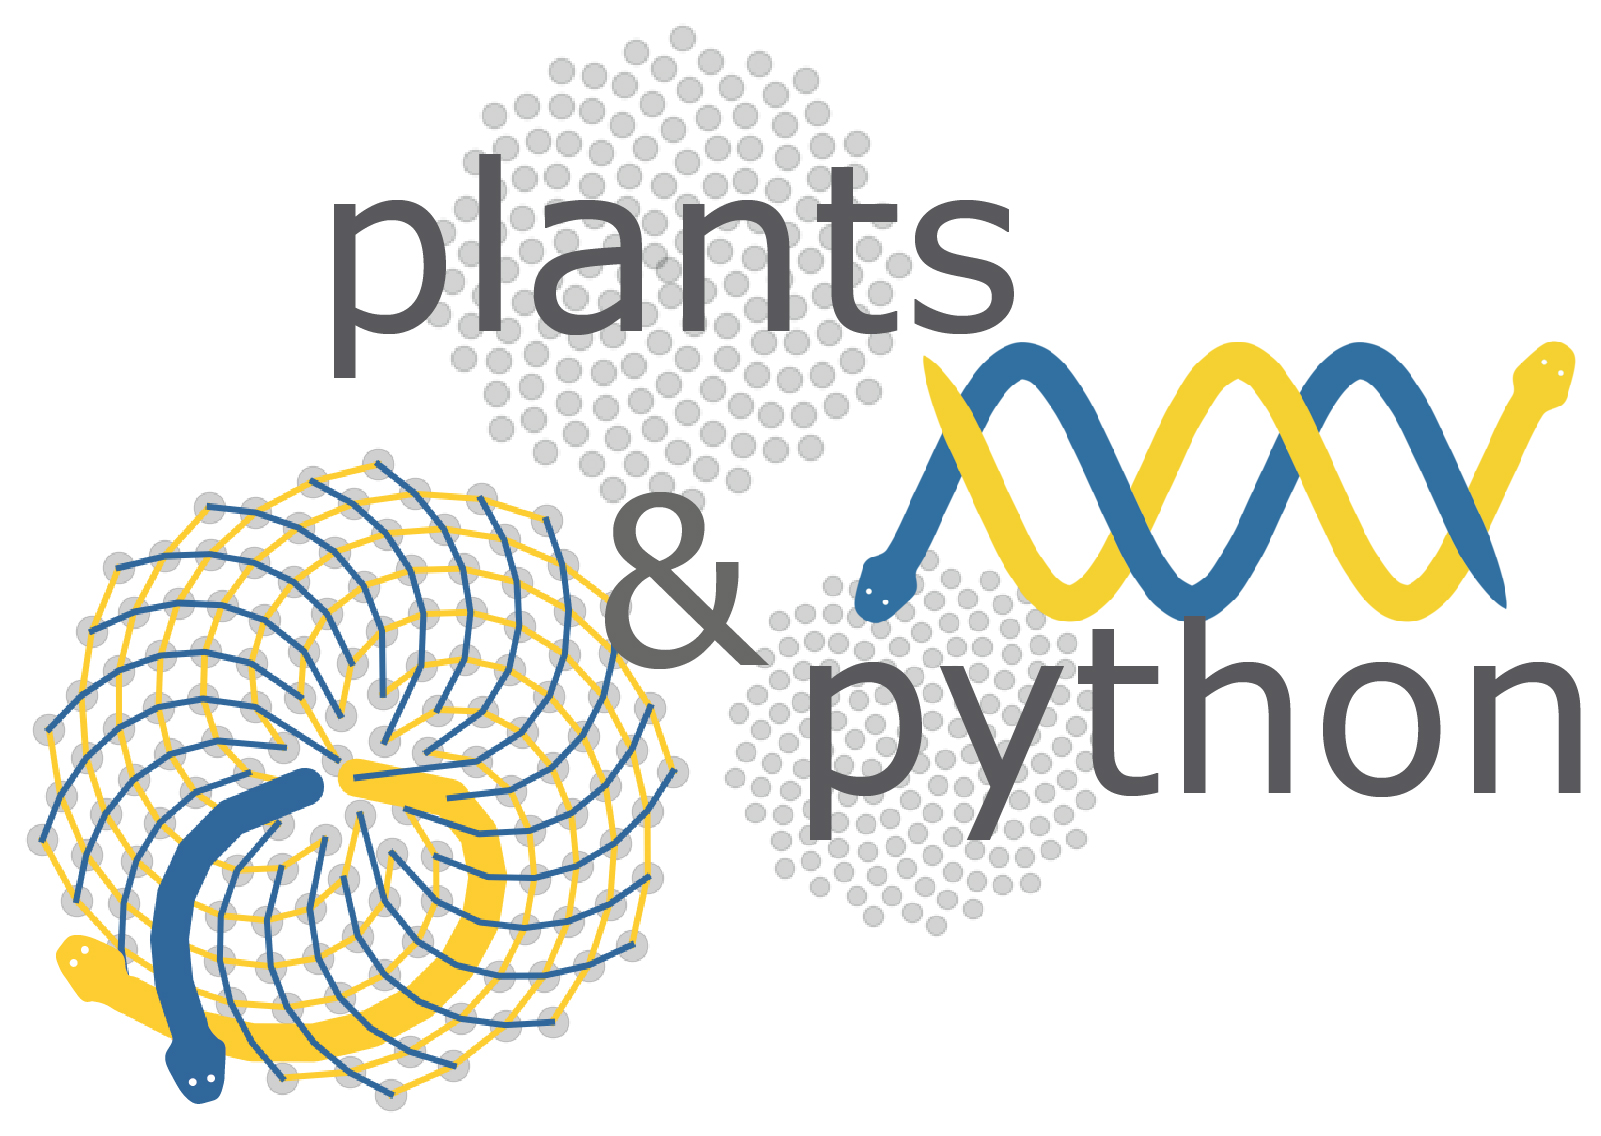

# Practice: Variant discovery, genetic diversity, and population genetics
So far we have seen how Illumina short read data can be used to quantify elements in the genome and find differences in gene expression, small RNA accumulation, methylation, chromatin accessibility, and transcription factor binding, among others. These approaches align the reads against a reference genome to count how many align to a specific region for quantification, but ignore the actual sequence information contained in the reads. In RNAseq data for instance, there can be sequence differences between the RNAseq reads and the reference genome, but we ignore this information as we only care about how many reads align per gene. What if we care about the actual sequence? <br>
<br>
We can use Illumina data to identify differences between a reference genome and another individual. We could look at differences across varieties, cultivars or accessions of a crop plant. We could sequence siblings in a mapping population and identify which alleles they have. We could also identify causal mutations in an EMS, fast neutron, or transposon based mutant populaton. In all of these cases the workflow is the same, and the first step is to identify _variants_ or differences between the reference genome and our individual of interest. Using Illumina data, we can identify single nucleotide polymorphisms (or SNPs) which represent base pair differences (e.g. A -> G, C -> T, etc.), or we can identify short insertions or deletions (InDels) which represent differences that span a couple base pairs (e.g. a deletion of ACC or an insertion of GTGA). <br> <br>
Identifying variants is significantly more computationally intensive than mapping RNAseq data, so we will not be doing it in this notebook (but the workflow is described below for those who are interested). Instead, we will learn about how to manipultate the output variant dataframes (VCF files) and simple downstream analyses of genetic diversity and population genetics. In this notebook, we will work with variant data for wild and domesticated pineapple and grape, but these approaches can be applied to your favorite species!

# Reading, manipulating, and analyzing VCF files

Like everything, there are many programs that we can use to read, manipulate, and analyze VCF files. There is even a python library! Here, we will use the package `scikit-allel` and analyze filtered VCF files from pineapple and grape (Vitis species). GATK produces a large raw VCF file that needs to be filtered (10-1,000 gigabytes, depending on how many variants, individuals, and genome size). Its not uncommon to get 10 or >100 million variants in a project, and not all of these are high confidence, and for some analyses, you only need a subset of the data. We can use `scikit-allel` to filter VCF files, but it is slow. The best program to filter VCF files is VCF-tools and it can be run on HPCC. It has a lot of functionality and can also be used for basic population genetics and genetic diversity analyses: <br>
https://vcftools.github.io/man_latest.html
<br>
I have already used VCFtools to filter both the pineapple and grape datasets to make them more manageable for this notebook. We will import the filted files. 

The `scikit-allel` package provides utilities for exploratory analysis of large scale genetic variation data. It is based on numpy, scipy and other general-purpose Python scientific libraries. We need to install `scikit-allel`, and the simplest way is to use Conda. Conda quickly installs, runs and updates packages and their dependencies. Conda easily creates, saves, loads, and switches between environments on your local computer. You should be able to install it by running the following command in Jupyter, but you can also run this on the Anaconda command prompt (note this may take a few minutes to update/install all of the dependencies in the conda environment): 



In [1]:
conda install -c conda-forge scikit-allel

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Bob\Anaconda3

  added / updated specs:
    - scikit-allel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.11.0               |   py37h03978a9_0        16.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        16.9 MB

The following packages will be UPDATED:

  conda                               4.10.3-py37h03978a9_2 --> 4.11.0-py37h03978a9_0




conda-4.11.0         | 16.9 MB   |            |   0% 
conda-4.11.0         | 16.9 MB   |            |   0% 
conda-4.11.0         | 16.9 MB   | 6          |   7% 
conda-4.11.0         | 16.9 MB   | #4         |  14% 
conda-4.11.0         | 16.9 MB   | ##2        |  23% 
conda-4.11.0         | 16.9 MB   | ###1       |  32% 
conda-4.11.0         | 16.9 MB   | ##

Once 'conda install' is run, we can verify that the package was installed correctly. 

In [2]:
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.2


We'll need some other stuff too: 

In [3]:
import random
random.seed(42)
import time
import numpy as np
np.random.seed(42)
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel

The first step is to read in the vcf file, and we'll do this using allel.read_vcf. We will use `fields='*'` to import all the fields:

In [4]:
pineapple = allel.read_vcf('Practice11_pineapple_downsampled.vcf', fields='*')

Now lets look at the vcf file we imported: 

In [5]:
print(pineapple)

{'samples': array(['Ac73p', 'Ac71q', 'Ac64s', 'Ac68s', 'Ac70q', 'Ac63s', 'Ac62s',
       'Ac61q', 'Ac72q', 'Ac74p', 'A01', 'Aa02', 'Aa03', 'Aa04', 'Aa05',
       'Aa06', 'Aa07', 'Aa08', 'Ac20q', 'Ab10', 'Ab11', 'Ab12', 'Ab13',
       'Ab14', 'Ab15', 'Ab16', 'Ac17c', 'Ac18c', 'Ac19s', 'Ab09', 'Ac21c',
       'Ac22a', 'Ac23c', 'Ac24a', 'Ac25', 'Ac26', 'Ac27', 'Ac28', 'Ac29',
       'Ac30', 'Ac31', 'Ac32s', 'Ac33c', 'Ac34', 'Ac35', 'Ac36', 'Ac37',
       'Ac38c', 'Ac39c', 'Ac40s', 'Ac41c', 'Ac42c', 'Ac43c', 'Ac44c',
       'Ac45c', 'Ac46c', 'Ac47c', 'Ac48', 'Ac49', 'Ac50', 'Ae51', 'Ae52',
       'Cs53', 'Ac80', 'Ac67s', 'Ac78s', 'Ac76s', 'Ac60s', 'Ac85s',
       'Ac66s', 'Ac86m', 'Ac81', 'Ac59p', 'Ac58s', 'Ac82', 'Ac57q',
       'Ac83', 'Ac69s', 'Ac65m', 'Ac56m', 'Ac87s', 'Aa88', 'Ac89s',
       'Ac79s', 'Ac75m', 'Ac84', 'Ac77m'], dtype=object), 'calldata/AD': array([[[-1, -1, -1, -1],
        [16,  8, -1, -1],
        [10, 12, -1, -1],
        ...,
        [-1, -1, -1, -1],
        [-1, 

This is basically a raw NumPy array, so it's not intuitive to read if you are a human.  We can import it as a dataframe instead, so that we fellow humans can interpret it. **Note:** we aren't going to do anything with this NumPy array, _but you could_. 
<br> <br>
Importing the vcf file as a dataframe:

In [6]:
pineapple_df = allel.vcf_to_dataframe('Practice11_pineapple_downsampled.vcf', fields='*', alt_number=2)
pineapple_df

,CHROM,POS,ID,REF,ALT_1,ALT_2,QUAL,AC_1,AC_2,AF_1,...,MQ0,MQRankSum,QD,ReadPosRankSum,FILTER_PASS,FILTER_LowQual,numalt,altlen_1,altlen_2,is_snp
0,LG01,1453,.,G,A,NaN,7104.189941,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
1,LG01,6534,.,C,T,NaN,2832.270020,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
2,LG01,11630,.,T,C,NaN,10166.299805,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
3,LG01,20856,.,A,G,NaN,2718.949951,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
4,LG01,30750,.,C,T,NaN,2220.870117,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20296,LG11,2046631,.,C,A,NaN,3457.639893,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
20297,LG11,2052626,.,A,G,NaN,3804.000000,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
20298,LG11,2057863,.,C,A,NaN,2181.320068,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True
20299,LG11,2064887,.,C,T,NaN,2292.040039,-1,-1,NaN,...,-1,NaN,NaN,NaN,False,False,1,0,0,True


The  object returned by read_vcf() is a Python dictionary with several NumPy arrays, each of which can be accessed via a key. Lets see the available keys:

In [7]:
sorted(pineapple.keys())

['calldata/AD',
 'calldata/DP',
 'calldata/GQ',
 'calldata/GT',
 'calldata/MIN_DP',
 'calldata/PL',
 'calldata/SB',
 'samples',
 'variants/AC',
 'variants/AF',
 'variants/ALT',
 'variants/AN',
 'variants/BaseQRankSum',
 'variants/CHROM',
 'variants/ClippingRankSum',
 'variants/DP',
 'variants/DS',
 'variants/END',
 'variants/FILTER_LowQual',
 'variants/FILTER_PASS',
 'variants/FS',
 'variants/HaplotypeScore',
 'variants/ID',
 'variants/InbreedingCoeff',
 'variants/MLEAC',
 'variants/MLEAF',
 'variants/MQ',
 'variants/MQ0',
 'variants/MQRankSum',
 'variants/POS',
 'variants/QD',
 'variants/QUAL',
 'variants/REF',
 'variants/ReadPosRankSum',
 'variants/altlen',
 'variants/is_snp',
 'variants/numalt']

As you can see, there are many keys, and you can learn more about each key in the description of vcf files above. The `samples` array contains sample identifiers extracted from the header line in the VCF file. We can use these later on when we plot things:



In [8]:
pineapple['samples']

array(['Ac73p', 'Ac71q', 'Ac64s', 'Ac68s', 'Ac70q', 'Ac63s', 'Ac62s',
       'Ac61q', 'Ac72q', 'Ac74p', 'A01', 'Aa02', 'Aa03', 'Aa04', 'Aa05',
       'Aa06', 'Aa07', 'Aa08', 'Ac20q', 'Ab10', 'Ab11', 'Ab12', 'Ab13',
       'Ab14', 'Ab15', 'Ab16', 'Ac17c', 'Ac18c', 'Ac19s', 'Ab09', 'Ac21c',
       'Ac22a', 'Ac23c', 'Ac24a', 'Ac25', 'Ac26', 'Ac27', 'Ac28', 'Ac29',
       'Ac30', 'Ac31', 'Ac32s', 'Ac33c', 'Ac34', 'Ac35', 'Ac36', 'Ac37',
       'Ac38c', 'Ac39c', 'Ac40s', 'Ac41c', 'Ac42c', 'Ac43c', 'Ac44c',
       'Ac45c', 'Ac46c', 'Ac47c', 'Ac48', 'Ac49', 'Ac50', 'Ae51', 'Ae52',
       'Cs53', 'Ac80', 'Ac67s', 'Ac78s', 'Ac76s', 'Ac60s', 'Ac85s',
       'Ac66s', 'Ac86m', 'Ac81', 'Ac59p', 'Ac58s', 'Ac82', 'Ac57q',
       'Ac83', 'Ac69s', 'Ac65m', 'Ac56m', 'Ac87s', 'Aa88', 'Ac89s',
       'Ac79s', 'Ac75m', 'Ac84', 'Ac77m'], dtype=object)

Now, lets take a step back, where did this data come from? This data is from a recent paper on the domestication history of pineapple: 
https://www.nature.com/articles/s41588-019-0506-8

In this paper, we resequenced ~90 accessions of pineapple from around the world and a few dozen wild species as well. We will be replicating a few of the analyses in this paper. <br>

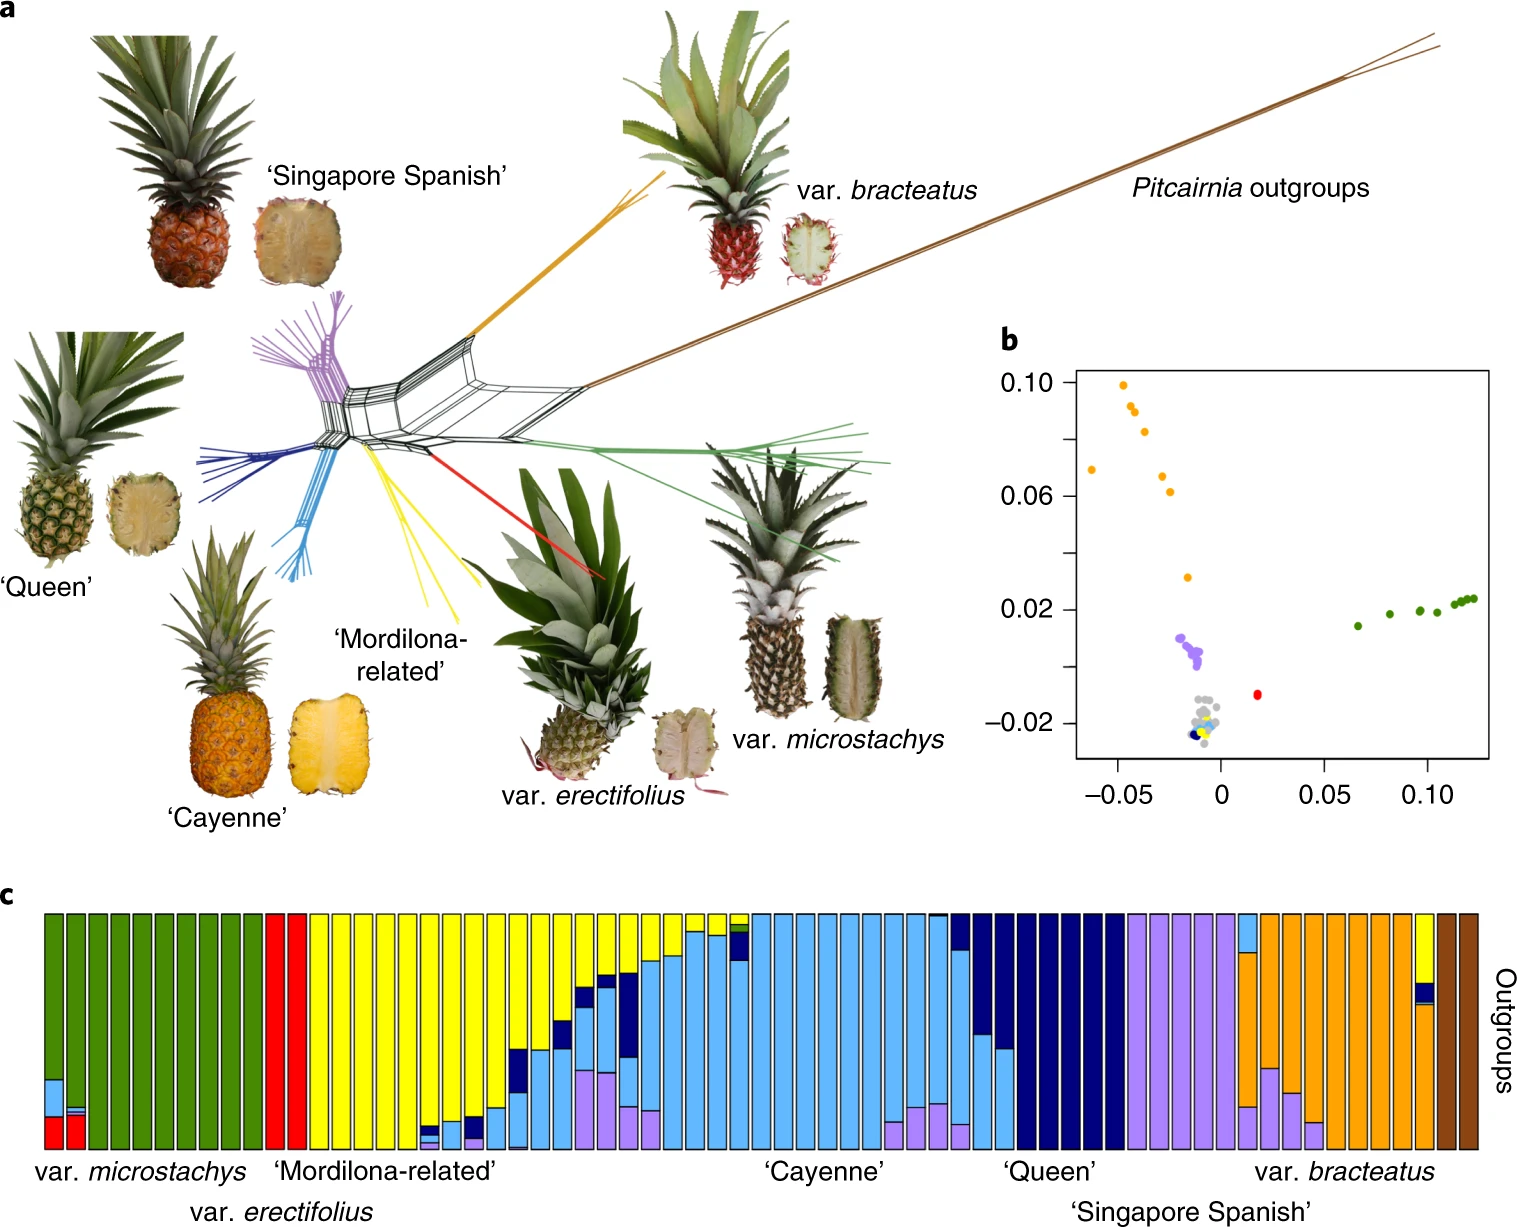

In this notebook, we imported a simplified vcf file containing a subset of the variants that were used in this paper. We can treat the file of variants as a character matrix and similar to the leaf shape and RNAseq data, use a principle component analysis to describe the data. There should be distinct sets of variants that are found in _only_ domesticated and _only_ wild pineapple, and they should lead to a strong separation of the two groups. The wild progenitor species of pineapple should contain a subset of variants that are shared with pineapple, so we might extpect these to be closer to the cultivated accessions than the wild. 

To run a PCA, we need a simple dataframe of integers (0, 1, and 2) instead of the complex numpy arrays we have after importing a vcf file. We can use the `allel.GenotypeChunkedArray` function to pull out only the genotype data (key 'calldata/GT'):

In [9]:
g = allel.GenotypeChunkedArray(pineapple['calldata/GT'])
g

<GenotypeChunkedArray shape=(20301, 87, 2) dtype=int8
   nbytes=3.4M
   values=numpy.ndarray>

This is simpler, but still not a simple enough input to run a PCA. We can use the `to_n_alt()` function transform each genotype call into the number of non-reference alleles. In this case, a 0/0 would be transformed into 0, 0/1 into 1, and 1/1 into 2:

In [10]:
gn = g.to_n_alt()
gn

<ChunkedArrayWrapper shape=(20301, 87) dtype=int8 chunks=(5076, 87)
   nbytes=1.7M cbytes=631.4K cratio=2.7
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

Then, we can use the `allel.pca` function to run the principle component analysis (PCA). We need to feed it our simplified array, the number of components (set to 10), and the scaler (Patterson is based on the methods from the first paper to use PCA to survey genetic diversity):

In [11]:
coords1, model1 = allel.pca(gn, n_components=2, scaler='patterson')

Finally, we can plot the PCA. We will use matplotlib as we've done in the past. We will use the 'samples' array to label each sample. <br>
Note: This PCA is pretty ugly and hard to interpret as is. See if you can relabel each data point or recolor the points by species or cultivar group. 

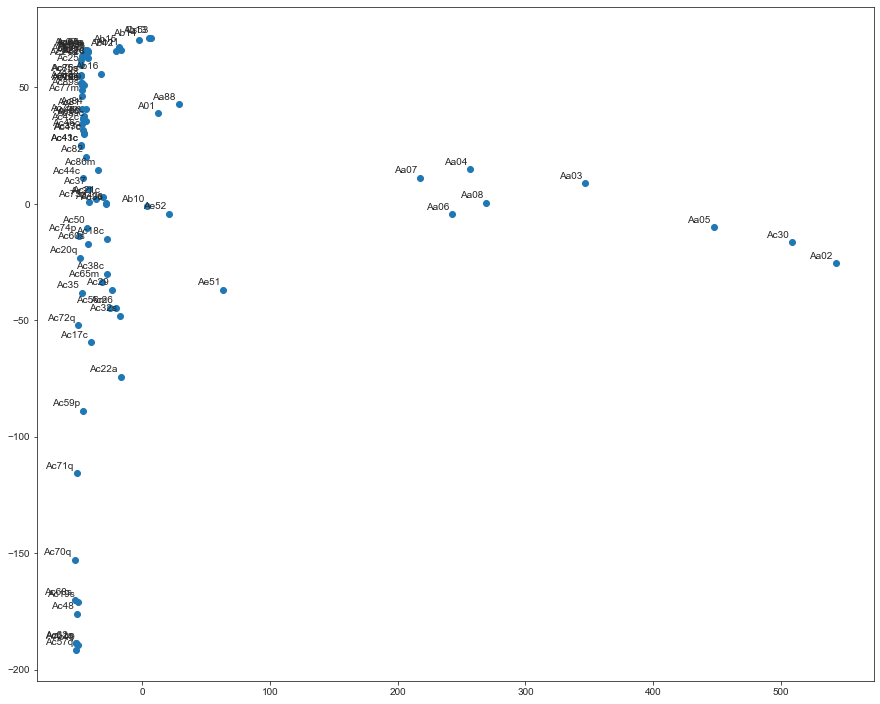

In [12]:
#plt.scatter(coords1[:,0], coords1[:,1])
import matplotlib.pyplot as plt

labels = pineapple['samples']
colors = pineapple['samples']
plt.figure(figsize=(15, 12))
plt.subplots_adjust(bottom=0.1)
plt.scatter(coords1[:,0],coords1[:,1], label='True Position')

for label, x, y in zip(labels, coords1[:, 0], coords1[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

We can similarly group the genetic data using a Hierarchical Clustering approach. This is similar to PCA and is often congruent with a phylogenetic approach. Below, samples are broken down into wild pineapple (in green) and domesticated (red):

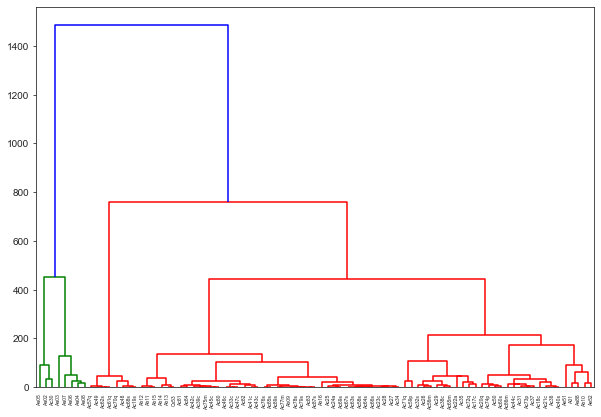

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(coords1, 'ward')

labelList = pineapple['samples']

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

# Bringing it together

We can apply this same framework to grape. Dan's collaborators have collected genotype data for diverse Vitis accessions. This includes many domesticated grape varieties and wild grape species. We previously used PCA with the shape data to cluster the accessions, but how does this compare to genotype data? Using the provided grape vcf file, run a PCA and heirarchical cluster. I have also provided a sample dataframe and you can get creative to color the samples by species instead of labeling them. How does this compare to the previous PCA based on shape alone? <br>
The grape vcf file is derived from GBS data, and Dan's collaborator has heavily filtered the vcf file to contain only biallelic SNPs, with high depth and low missing data rates. 

In [15]:
## Load the grape vcf file
grape = allel.read_vcf('Practice11_Grape.biallele.depth.missing.recode.recalc.vcf')

How many vitis accessions are in this vcf file?

In [19]:
# Answer: 584
grape['samples']

array(['1625_a:C2C7HACXX:8:250232525', '1625_b:C2C7HACXX:8:250232526',
       '1626_a:C2C7HACXX:8:250232527', '1626_b:C2C7HACXX:8:250232528',
       '1626_c:C2C7HACXX:8:250232529', '1627_a:C2C7HACXX:8:250232530',
       '1627_b:C2C7HACXX:8:250232531', '1627_c:C2C7HACXX:8:250232532',
       '1628_a:C2C7HACXX:8:250232533', '1628_b:C2C7HACXX:8:250232534',
       '1628_c:C2C7HACXX:8:250232535', '1664_c:C2C9HACXX:3:250225624',
       '1664_j:C2C9HACXX:3:250225625', '1664_k:C2C9HACXX:3:250225626',
       '1664_m:C2C9HACXX:3:250225651', '1664_n:C2C9HACXX:3:250225652',
       '1665_a:C2C7HACXX:8:250232511', '1665_b:C2C7HACXX:8:250232512',
       '1665_d:C2C7HACXX:8:250232514', '1665_e:C2C7HACXX:8:250232515',
       '1665_f:C2C7HACXX:8:250232516', '1665_g:C2C7HACXX:8:250232517',
       '1665_h:C2C7HACXX:8:250232518', '1665_i:C2C7HACXX:8:250232520',
       '1665_k:C2C7HACXX:8:250232521', '1665_l:C2C7HACXX:8:250232522',
       '1665_m:C2C7HACXX:8:250232523', '1665_n:C2C7HACXX:8:250232524',
      

How many variants are in this vcf file? 

In [20]:
##Answer: 11053
g = allel.GenotypeChunkedArray(grape['calldata/GT'])
g

<GenotypeChunkedArray shape=(11053, 584, 2) dtype=int8
   nbytes=12.3M
   values=numpy.ndarray>

Run and plot a PCA from this datset
Note, the code I provided above makes a pretty ugly PCA, how might you change the plotting/colors to make it more easily interpretable? 

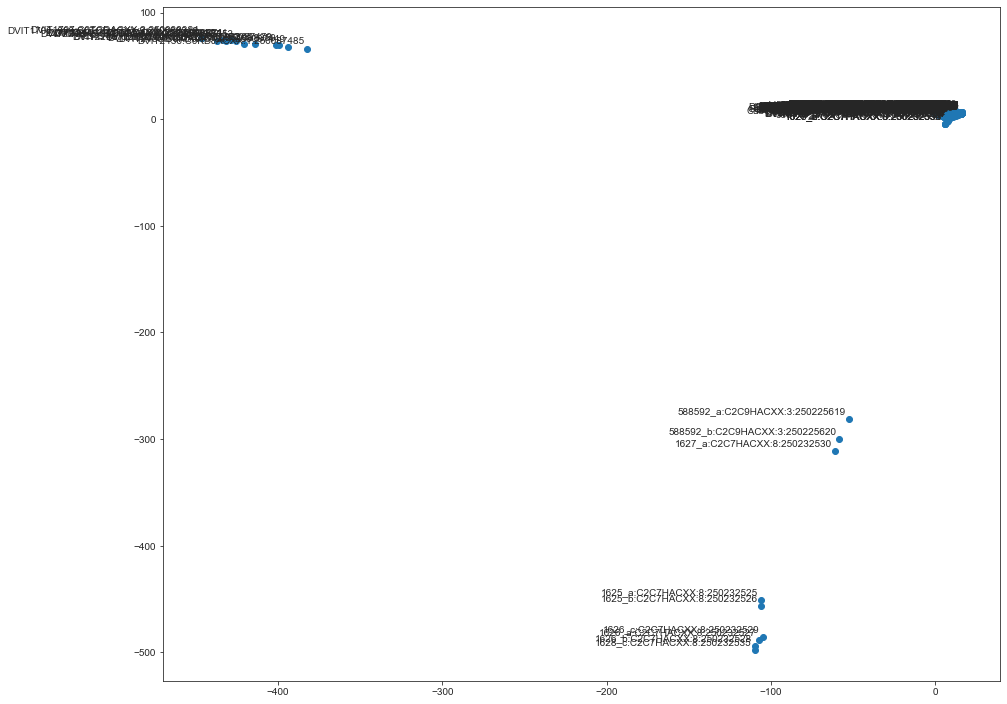

In [23]:
##Answer
gn = g.to_n_alt()
gn
coords1, model1 = allel.pca(gn, n_components=2, scaler='patterson')
import matplotlib.pyplot as plt

labels = grape['samples']
colors = grape['samples']
plt.figure(figsize=(15, 12))
plt.subplots_adjust(bottom=0.1)
plt.scatter(coords1[:,0],coords1[:,1], label='True Position')

for label, x, y in zip(labels, coords1[:, 0], coords1[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

Run a Hierarchical Clustering and plot a dendrogram of the grape dataset

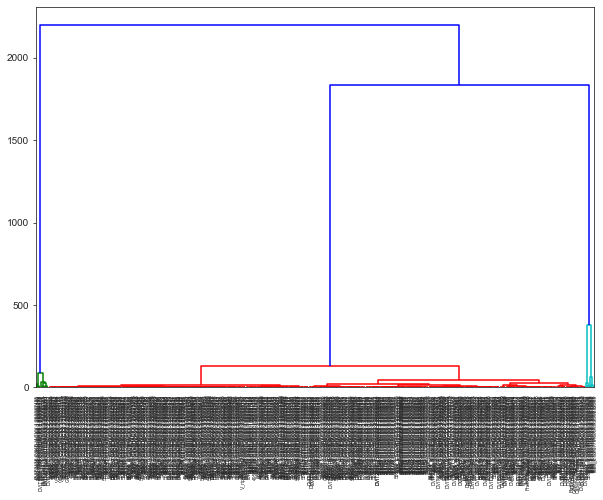

In [24]:
##Answer
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(coords1, 'ward')

labelList = grape['samples']

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()